## The purpose of the Capstone 2 project is to determine whether or not the lesion in an image is malignant or not 

import necessary libraries

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

/home/seo/environments/my_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/seo/environments/my_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/seo/environments/my_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/seo/environments/my_env/lib/python3.6/site-packages/ten

For this image segmentation, the input images have to be a certain size. Therefore, the image size are determined at 128 by 128.

In [2]:
# Set some parameters
im_width = 128
im_height = 128

Get the path of the ISIC data and the associated mask images. Both were acquired through ISIC image segmentation challenge 2018.

In [3]:
image_path='./Data/Images'
meta_path='./Data/Descriptions'

imagelist=os.listdir(image_path)
metalist=os.listdir(meta_path)

pics=[file for file in imagelist]
meta=[file for file in metalist]

masklist=os.listdir("/home/seo/Masks")
masks=[file for file in masklist if file.endswith(".png") and file.startswith("ISIC")]

In [4]:
import pickle
name="isic_data"
df=pickle.load(open(name,"rb"))

In [5]:
df.drop_duplicates(subset ="name") 

,_id,_modelType,created,creator._id,creator.name,dataset._accessLevel,dataset._id,dataset.description,dataset.license,dataset.name,...,meta.unstructured.race,meta.unstructured.site,meta.unstructured.ulcer,meta.unstructured.vertical,name,notes.reviewed.accepted,notes.reviewed.time,notes.reviewed.userId,notes.tags,updated
0,558d618dbae47801cf734963,image,2015-06-26T14:28:29.770000+00:00,54cb974fbae47819d8e4c727,User GQZH,0,5a2ecc5d1165975c94594284,Biopsy-confirmed melanocytic and non-melanocyt...,CC-0,MSK-2,...,NaN,NaN,NaN,NaN,ISIC_0010281,True,2015-07-02T18:01:14.906000+00:00,5450e996bae47865794e4d0d,[],2015-10-02T15:33:45.996000+00:00
1,550902ddbae478359aa587e2,image,2015-03-18T04:45:17.559000+00:00,54cb974fbae47819d8e4c727,User GQZH,0,5a2ecc5e1165975c945942a0,Moles in children.\nBenign melanocytic lesions...,CC-0,SONIC,...,White,NaN,NaN,NaN,ISIC_0008546,True,2015-08-21T16:57:37.376000+00:00,55d5e0ce9fc3c10470dba1a1,[],2015-12-09T14:46:29.099000+00:00
2,558d60c7bae47801cf7344ef,image,2015-06-26T14:25:11.490000+00:00,54cb974fbae47819d8e4c727,User GQZH,0,5a2ecc5d1165975c94594284,Biopsy-confirmed melanocytic and non-melanocyt...,CC-0,MSK-2,...,NaN,NaN,NaN,NaN,ISIC_0010002,True,2015-06-30T16:07:42.665000+00:00,5450e996bae47865794e4d0d,"[ISBI 2016: Training, ISBI 2017: Training, Cha...",2015-10-02T15:33:45.247000+00:00
3,5509024abae478359aa581b6,image,2015-03-18T04:42:50.391000+00:00,54cb974fbae47819d8e4c727,User GQZH,0,5a2ecc5e1165975c945942a0,Moles in children.\nBenign melanocytic lesions...,CC-0,SONIC,...,White,NaN,NaN,NaN,ISIC_0008230,True,2015-08-21T16:56:54.380000+00:00,55d5e0ce9fc3c10470dba1a1,[],2015-12-03T18:13:54.693000+00:00
4,54e7dd1dbae4780ec59cdaa9,image,2015-02-21T01:19:25.499000+00:00,54cb974fbae47819d8e4c727,User GQZH,0,5a2ecc5e1165975c945942a0,Moles in children.\nBenign melanocytic lesions...,CC-0,SONIC,...,White,NaN,NaN,NaN,ISIC_0004013,True,2015-08-21T16:37:07.822000+00:00,55d5e0ce9fc3c10470dba1a1,[],2015-12-04T14:09:01.546000+00:00
5,558d60aebae47801cf73445c,image,2015-06-26T14:24:46.931000+00:00,54cb974fbae47819d8e4c727,User GQZH,0,5a2ecc5d1165975c94594284,Biopsy-confirmed melanocytic and non-melanocyt...,CC-0,MSK-2,...,NaN,NaN,NaN,NaN,ISIC_0009953,True,2015-06-30T16:05:45.307000+00:00,5450e996bae47865794e4d0d,"[ISBI 2016: Training, ISBI 2017: Training, Cha...",2015-10-02T15:33:45.132000+00:00
6,54e7d950bae4780ec59cc198,image,2015-02-21T01:03:12.323000+00:00,54cb974fbae47819d8e4c727,User GQZH,0,5a2ecc5e1165975c945942a0,Moles in children.\nBenign melanocytic lesions...,CC-0,SONIC,...,White,NaN,NaN,NaN,ISIC_0002730,True,2015-08-21T16:18:23.842000+00:00,55d5e0ce9fc3c10470dba1a1,[],2015-12-03T18:13:43.232000+00:00
7,5aaf149a116597691363aa63,image,2018-03-19T01:38:34.651000+00:00,5a95992d116597381f5ebab2,User 5KJX,0,5aaf6f2a116597691367292e,Dermatoscopic images of the most common classe...,CC-BY-NC,HAM10000,...,NaN,NaN,NaN,NaN,ISIC_0030318,True,2018-03-22T19:59:46.237000+00:00,55d4cde89fc3c1490e995086,"[Challenge 2018: Task 3: Training, Challenge 2...",2018-03-19T01:38:34.651000+00:00
8,5aaf14261165976913637074,image,2018-03-19T01:36:38.915000+00:00,5a95992d116597381f5ebab2,User 5KJX,0,5aaf6f2a116597691367292e,Dermatoscopic images of the most common classe...,CC-BY-NC,HAM10000,...,NaN,NaN,NaN,NaN,ISIC_0029158,True,2018-03-22T19:58:08.353000+00:00,55d4cde89fc3c1490e995086,"[Challenge 2018: Task 3: Training, Challenge 2...",2018-03-19T01:36:38.915000+00:00
9,5508ffcbbae47817cee4dcf0,image,2015-03-18T04:32:11.778000+00:00,54cb974fbae47819d8e4c727,User GQZH,0,5a2ecc5e1165975c945942a0,Moles in children.\nBenign melanocytic lesions...,CC-0,SONIC,...,Asian,NaN,NaN,NaN,ISIC_0007502,True,2015-08-21T16:34:44.117000+00:00,55d5e0ce9fc3c10470dba1a1,[],2015-12-03T18:13:53.234000+00:00


In [6]:
sonics=df[df['dataset.name'] == 'SONIC']['name']

In [7]:
mask2=[file.split('_segmentation')[0] for file in masklist if file.endswith(".png") and file.startswith("ISIC") and file not in sonics]
test_pics=[file for file in pics if file.split('.jpeg')[0] in mask2]

Only the images that has the corresponding mask image were selected as test images

In [8]:
ids=test_pics
print("No. of images = ", len(ids))

No. of images =  2594


In [9]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [35]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img(image_path+'/'+str(id_), grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("/home/seo/Masks/"+id_.split('.')[0]+'_segmentation.png', grayscale=True))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

KeyboardInterrupt: 

After acquiring the images and resizing them, the data were saved as pickle for future use as the procedure takes a while

In [ ]:
import pickle
with open('X.pickle', 'wb') as f:
    pickle.dump(X, f)
with open('y.pickle', 'wb') as f:
    pickle.dump(y, f)

In [10]:
import pickle

X=pickle.load(open('X.pickle',"rb"))
y=pickle.load(open('y.pickle',"rb"))

In [11]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

Create necessary function and build the UNET model. This code was adapted from the codes provided from towardsdatascience website (https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47)

In [12]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [13]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [14]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

W1013 17:01:52.680549 139691887499072 deprecation_wrapper.py:119] From /home/seo/environments/my_env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1013 17:01:52.701193 139691887499072 deprecation_wrapper.py:119] From /home/seo/environments/my_env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1013 17:01:52.704656 139691887499072 deprecation_wrapper.py:119] From /home/seo/environments/my_env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W1013 17:01:52.736507 139691887499072 deprecation_wrapper.py:119] From /home/seo/environments/my_env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated.

In [15]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128, 128, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 128, 128, 16) 0           batch_normalization_2[0][0]      
__________________________________________________________________________________________________
max_poolin

In [16]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

As this procedure also takes a while, the created model was saved for future use

In [17]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Train on 1967 samples, validate on 219 samples
Epoch 1/50
1967/1967 [==============================] - 183s 93ms/step - loss: 0.3846 - acc: 0.8231 - val_loss: 0.2534 - val_acc: 0.8883

Epoch 00001: val_loss improved from inf to 0.25344, saving model to model-tgs-salt.h5
Epoch 2/50
1967/1967 [==============================] - 184s 93ms/step - loss: 0.2447 - acc: 0.8845 - val_loss: 0.2571 - val_acc: 0.8829

Epoch 00002: val_loss did not improve from 0.25344
Epoch 3/50
1967/1967 [==============================] - 177s 90ms/step - loss: 0.2096 - acc: 0.8918 - val_loss: 0.2360 - val_acc: 0.8880

Epoch 00003: val_loss improved from 0.25344 to 0.23602, saving model to model-tgs-salt.h5
Epoch 4/50
1967/1967 [==============================] - 173s 88ms/step - loss: 0.1936 - acc: 0.8941 - val_loss: 0.1923 - val_acc: 0.8951

Epoch 00004: val_loss improved from 0.23602 to 0.19227, saving model to model-tgs-salt.h5
Epoch 5/50
1967/1967 [==============================] - 169s 86ms/step - loss: 0.180

In [18]:
with open('fit_model.pickle', 'wb') as f:
    pickle.dump(results, f)
with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)

In [19]:
import pickle

model=pickle.load(open('model.pickle',"rb"))

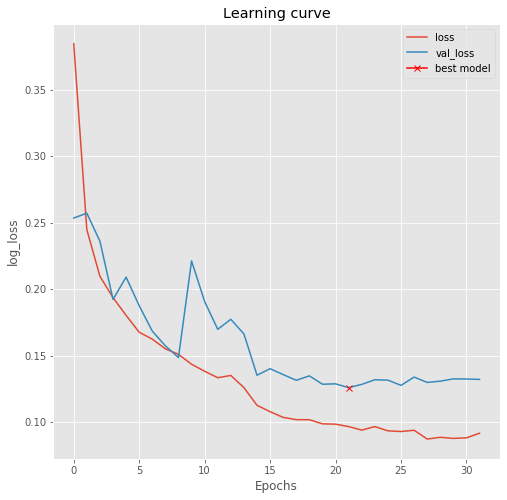

In [20]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [21]:
# Load best model
model.load_weights('model-tgs-salt.h5')

In [22]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

219/219 [==============================] - 4s 20ms/step


[0.1258529084798408, 0.9148919070692367]

In [23]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

219/219 [==============================] - 4s 16ms/step


Define a function to see the sample segmented data

In [24]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('lesion Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('lesion Predicted binary');

In [25]:
model.predict

<bound method Model.predict of <keras.engine.training.Model object at 0x7f0c27e4e400>>

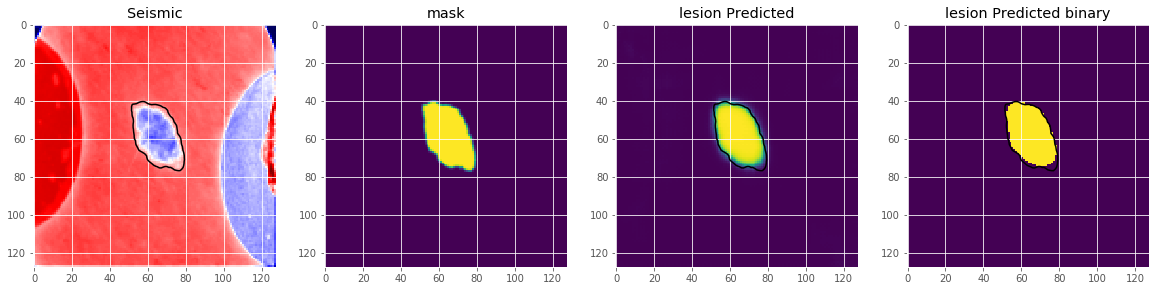

In [26]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=0)

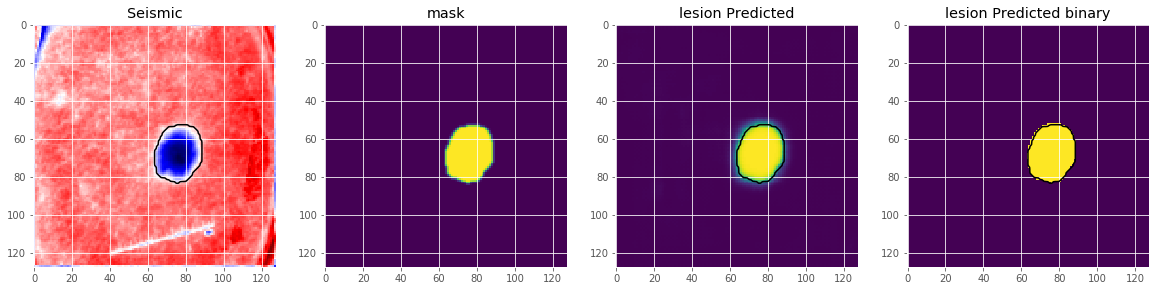

In [27]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=1)

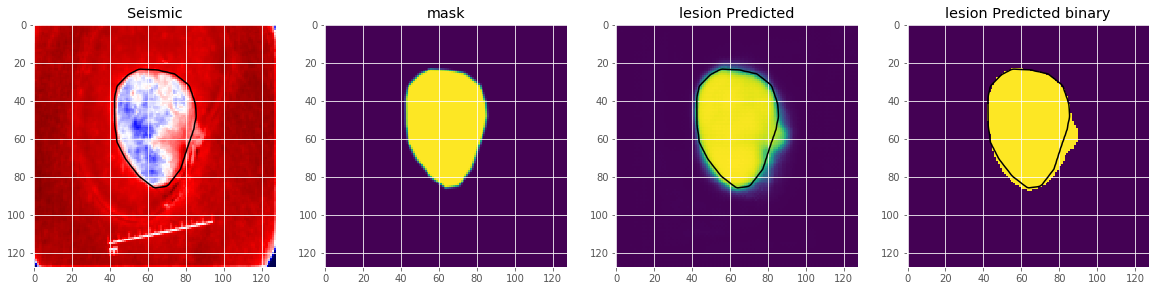

In [28]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)

Save the fitted model for future image segmentation process

In [29]:
with open('model_fitted.pickle', 'wb') as f:
    pickle.dump(model, f)

In [30]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128, 128, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 128, 128, 16) 0           batch_normalization_2[0][0]      
__________________________________________________________________________________________________
max_poolin